<font size="36">Install Dependencies</font>

In [1]:
#1. Import Dependencies

import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import keras
import pandas as pd

<font size="36">Use MediaPipe</font>

In [2]:
mp_holistic=mp.solutions.holistic
mp_drawing=mp.solutions.drawing_utils
mp_face_mesh=mp.solutions.face_mesh

In [3]:
def mediapipe_detection(image,model):
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #Color Conversion BGR 2 RGB
    image.flags.writeable=False # Image is no longer writeable
    results=model.process(image)    # Make prediction
    image.flags.writeable=True  # Image is now writeable
    image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR) #Color Conversion RGB w BGR
    return image,results


In [4]:
def draw_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_holistic.FACEMESH_CONTOURS) # Draw pose connection


In [5]:
def draw_styled_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80,110,10),thickness=1,circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121),thickness=1,circle_radius=1)
                             ) # Draw face connections
    mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10),thickness=2,circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121),thickness=2,circle_radius=2)
                             ) # Draw pose connection


In [ ]:
cap=cv2.VideoCapture(0)

# Access mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    face_mesh=mp_face_mesh.FaceMesh(max_num_faces=10,refine_landmarks=True,min_detection_confidence=0.5,min_tracking_confidence=0.5) 
    while cap.isOpened():
        # Read feed
        ret,frame=cap.read()
        
        # Make qdetections
        image,results=mediapipe_detection(frame,holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image,results)
        
        # Draw iris landmarks
        img_h,img_w=frame.shape[:2]
        results_iris=face_mesh.process(frame)
        
        mask = np.zeros((img_h, img_w), dtype=np.uint8)
        
        if results_iris.multi_face_landmarks:
            mesh_points=np.array([np.multiply([p.x, p.y], [img_w, img_h]).astype(int)
                                  for p in results_iris.multi_face_landmarks[0].landmark])
            (l_cx, l_cy), l_radius = cv2.minEnclosingCircle(mesh_points[LEFT_IRIS])
            (r_cx, r_cy), r_radius = cv2.minEnclosingCircle(mesh_points[RIGHT_IRIS])
            center_left = np.array([l_cx, l_cy], dtype=np.int32)
            center_right = np.array([r_cx, r_cy], dtype=np.int32)
            cv2.circle(image, center_left, int(l_radius), (0,255,0), 2, cv2.LINE_AA)
            cv2.circle(image, center_right, int(r_radius), (0,255,0), 2, cv2.LINE_AA)
            cv2.circle(mask, center_left, int(l_radius), (255,255,255), -1, cv2.LINE_AA)
            cv2.circle(mask, center_right, int(r_radius), (255,255,255), -1, cv2.LINE_AA)
            
        
        # Show to screen
        #cv2.imshow('Mask', mask)
        cv2.imshow('OpenCV Feed',image)
        
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

In [ ]:
results.face_landmarks

In [ ]:
len(results.face_landmarks.landmark)

In [ ]:
results.face_landmarks.landmark[159]

In [ ]:
results.eye_landmarks

In [ ]:
len(results.pose_landmarks.landmark)

In [ ]:
draw_styled_landmarks(frame, results)

In [ ]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

<font size="36">Extract Landmarks</font>

In [6]:
def extract_keypoints(results):
    face=np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    pose=np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)

    return np.concatenate([face])

<font size="36">Setup Folders for Collection</font>

In [7]:
# Path for exported data, numpy arrays
DATA_PATH=os.path.join('Training_Data')

# Actions that we try to detect
actions=np.array(['active','bored','distracted'])

#Fifteen video worth of data
no_sequences=30

# Videos are going to be 15 franes in length
sequence_length=30

In [8]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH,action,str(sequence)))
        except:
            pass         

<font size="36">Collect Keypoints</font>

In [9]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    face_mesh=mp_face_mesh.FaceMesh(max_num_faces=10,refine_landmarks=True,min_detection_confidence=0.5,min_tracking_confidence=0.5) 
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        cv2.waitKey(3000)
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
        
                ##################################################################################
           
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(3000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                print(keypoints)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

C:\Users\sriha\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


[ 0.57312667  0.53852242 -0.02037534 ...  0.64700258  0.34446731
  0.01279483]
[ 0.5168103   0.51454395 -0.02460127 ...  0.61256135  0.31000105
  0.00153108]
[ 0.51623249  0.51112056 -0.02325928 ...  0.61353201  0.30089426
  0.00224173]
[ 0.51487017  0.51069427 -0.02279661 ...  0.6114769   0.29717231
  0.00115629]
[ 0.51312083  0.50525045 -0.02418339 ...  0.61090487  0.29281437
  0.00207309]
[ 0.51211435  0.49688539 -0.02560486 ...  0.60755634  0.28750706
  0.00455349]
[ 0.50941283  0.49384946 -0.02493604 ...  0.60525239  0.28407311
  0.00319502]
[ 0.50967449  0.49403441 -0.02464322 ...  0.60438156  0.28354532
  0.00304278]
[ 0.5096209   0.49214756 -0.02407441 ...  0.60403055  0.28223604
  0.00255662]
[ 0.50705153  0.48827174 -0.02503365 ...  0.60055202  0.28222531
  0.00287372]
[ 0.50629914  0.48810285 -0.02512684 ...  0.59946114  0.28106919
  0.0026866 ]
[ 0.50695413  0.48824221 -0.02504881 ...  0.59944683  0.28053617
  0.00275308]
[ 0.50852424  0.48802677 -0.02482381 ...  0.60004407

[ 0.53280807  0.51852804 -0.0231189  ...  0.61575079  0.32684413
  0.01003981]
[ 0.53276682  0.51815957 -0.02307215 ...  0.61572903  0.32675725
  0.00990309]
[ 0.53230464  0.51826286 -0.02298632 ...  0.6160627   0.32748097
  0.00966417]
[ 0.53205186  0.51831609 -0.02274398 ...  0.6160354   0.32752013
  0.00918436]
[ 0.53234142  0.51816398 -0.02247906 ...  0.6159901   0.32711545
  0.00892521]
[ 0.53392965  0.51789409 -0.02290898 ...  0.61710584  0.32743728
  0.01003473]
[ 0.53434598  0.51833433 -0.02328228 ...  0.61753464  0.32694933
  0.01028098]
[ 0.53432816  0.51851362 -0.02326974 ...  0.61742353  0.32700753
  0.01028255]
[ 0.53424793  0.51819754 -0.02312885 ...  0.6175319   0.32752168
  0.01020411]
[ 0.53413659  0.51852298 -0.02303873 ...  0.61747444  0.32741815
  0.0100063 ]
[ 0.53383118  0.51844203 -0.02311557 ...  0.61720449  0.32739174
  0.00987933]
[ 0.53375942  0.51906025 -0.02254354 ...  0.61683977  0.32666981
  0.00928639]
[ 0.53120458  0.51737833 -0.02242359 ...  0.6154967 

[ 0.52546591  0.53667545 -0.02014567 ...  0.6086244   0.34709296
  0.00428386]
[ 0.52922595  0.53804231 -0.0209192  ...  0.61091697  0.35151094
  0.00631276]
[ 0.52974987  0.53933841 -0.02059247 ...  0.61146021  0.35166723
  0.00611634]
[ 0.53001404  0.53877431 -0.02089938 ...  0.61213231  0.35198665
  0.00658195]
[ 0.52981687  0.53879344 -0.02100671 ...  0.61204898  0.35200775
  0.0067432 ]
[ 0.5299536   0.53901452 -0.02073723 ...  0.61180627  0.35214671
  0.00678062]
[ 0.53013748  0.53924775 -0.02076728 ...  0.6118027   0.3519572
  0.0069168 ]
[ 0.53043187  0.53902841 -0.02086095 ...  0.6119777   0.35228783
  0.00760943]
[ 0.53041595  0.53900564 -0.02094916 ...  0.61202395  0.35205632
  0.0074853 ]
[ 0.53027529  0.53970999 -0.02053526 ...  0.61207187  0.35153571
  0.00722454]
[ 0.52969956  0.53968292 -0.02050961 ...  0.61178452  0.35165277
  0.00699969]
[ 0.52937073  0.54028618 -0.02040811 ...  0.61187893  0.3512089
  0.00636891]
[ 0.52965248  0.53974658 -0.02033066 ...  0.61238724  

[ 0.53335768  0.54359263 -0.02004339 ...  0.61649567  0.35196653
  0.00617381]
[ 0.53322232  0.54390788 -0.02006688 ...  0.61635268  0.35245287
  0.00639589]
[ 0.53347737  0.54396415 -0.02002339 ...  0.6162287   0.35269499
  0.00647176]
[ 0.53322268  0.544707   -0.01958857 ...  0.61624068  0.35229799
  0.00561588]
[ 0.5334599   0.54463744 -0.01973453 ...  0.61588359  0.35208803
  0.0059364 ]
[ 0.53335094  0.54467511 -0.01980769 ...  0.61595178  0.35222715
  0.00596569]
[ 0.53280485  0.54456359 -0.02027831 ...  0.61584431  0.3546645
  0.00652126]
[ 0.53285283  0.54410785 -0.02026199 ...  0.61563408  0.35447234
  0.00670532]
[ 0.53297514  0.54409319 -0.02023198 ...  0.61553466  0.35458416
  0.00685737]
[ 0.53324986  0.5445292  -0.02029482 ...  0.61585975  0.35474306
  0.0069728 ]
[ 0.53323215  0.54464805 -0.02017397 ...  0.61572593  0.35461485
  0.00691132]
[ 0.53255659  0.54478675 -0.01997133 ...  0.61524254  0.3552942
  0.00641938]
[ 0.53341043  0.54402161 -0.02011395 ...  0.61544394  

[ 0.52305108  0.54162103 -0.02026623 ...  0.60342318  0.35433751
  0.00790619]
[ 0.52318943  0.54217106 -0.01891332 ...  0.60369664  0.35104725
  0.00612495]
[ 0.52245229  0.54224956 -0.01948808 ...  0.60436738  0.35022634
  0.00657673]
[ 0.52265245  0.54217058 -0.01962977 ...  0.60432261  0.34978271
  0.00684795]
[ 0.52287972  0.54166579 -0.01994408 ...  0.60449749  0.35015416
  0.00750098]
[ 0.52252299  0.54185331 -0.01977278 ...  0.60392195  0.350144
  0.00711833]
[ 0.52239835  0.54192442 -0.02011451 ...  0.60408282  0.35068566
  0.00723115]
[ 0.52195519  0.54250765 -0.02028896 ...  0.60374451  0.35241008
  0.00704673]
[ 0.52242726  0.54234618 -0.02047678 ...  0.60391045  0.35200357
  0.00746001]
[ 0.52223474  0.54298401 -0.01996757 ...  0.60349292  0.35244536
  0.00679094]
[ 0.52223724  0.54301828 -0.01978135 ...  0.60359561  0.35121721
  0.00656448]
[ 0.52249962  0.54223061 -0.02016311 ...  0.60341346  0.35118973
  0.00740994]
[ 0.52152514  0.54233396 -0.01989179 ...  0.60350448  

[ 0.52004153  0.55386984 -0.01952599 ...  0.60391867  0.36399958
  0.00542492]
[ 0.52024764  0.55327463 -0.01901465 ...  0.60462278  0.3627654
  0.00440041]
[ 0.51972485  0.55203354 -0.01939244 ...  0.60454297  0.36262959
  0.00496298]
[ 0.52024537  0.55220199 -0.01954624 ...  0.60459179  0.3623074
  0.00511386]
[ 0.52098978  0.55239767 -0.01929293 ...  0.60499537  0.36221468
  0.00539855]
[ 0.52130675  0.55165809 -0.01950119 ...  0.60486287  0.36241195
  0.00618034]
[ 0.52154237  0.55220574 -0.01936003 ...  0.60493308  0.36214572
  0.00557907]
[ 0.52172393  0.55208504 -0.0194587  ...  0.60486776  0.36194727
  0.00611723]
[ 0.52133125  0.55196303 -0.01946194 ...  0.60485256  0.3624866
  0.00582682]
[ 0.52127302  0.55264479 -0.01897741 ...  0.60488486  0.36213183
  0.00481424]
[ 0.52106589  0.55404222 -0.01865935 ...  0.60425168  0.36392787
  0.00500023]
[ 0.52088434  0.55421281 -0.01845632 ...  0.60423332  0.36367425
  0.00408175]
[ 0.52095997  0.55450732 -0.01819402 ...  0.60419059  0

[ 0.51857889  0.56320596 -0.01804588 ...  0.60195118  0.37091786
  0.00311026]
[ 0.51724976  0.56122983 -0.01773917 ...  0.60086811  0.36934111
  0.00245413]
[ 0.51765132  0.56071758 -0.01810041 ...  0.60124832  0.36940745
  0.00370531]
[ 0.51778108  0.56165856 -0.01786773 ...  0.60140616  0.36944914
  0.00332624]
[ 0.5176717   0.56151181 -0.01831088 ...  0.60148442  0.36988729
  0.00402588]
[ 0.51756793  0.56148618 -0.01824467 ...  0.60172892  0.37019041
  0.00367003]
[ 0.51742107  0.5610432  -0.01824614 ...  0.60157561  0.3700178
  0.00361585]
[ 0.51741242  0.56094205 -0.01779586 ...  0.60130221  0.3690424
  0.00301876]
[ 0.51738095  0.56085604 -0.01782171 ...  0.60123128  0.36895394
  0.00335617]
[ 0.51827008  0.56094265 -0.01779479 ...  0.60138297  0.36831486
  0.00292076]
[ 0.51800448  0.56030691 -0.01768303 ...  0.60075557  0.36828536
  0.00348417]
[ 0.51818484  0.56088305 -0.01767317 ...  0.60086507  0.36775741
  0.00334183]
[ 0.5175432   0.56110924 -0.01766887 ...  0.60058904  

[ 0.51629061  0.55578339 -0.01851388 ...  0.5973146   0.36535591
  0.00491422]
[ 0.51622468  0.55584878 -0.01910928 ...  0.59716403  0.36608353
  0.00571158]
[ 0.51604176  0.55588651 -0.01927515 ...  0.5973717   0.36646858
  0.0057425 ]
[ 0.51560211  0.55600983 -0.01932226 ...  0.59739578  0.36673254
  0.00545145]
[ 0.5145424   0.55636197 -0.01936473 ...  0.5967077   0.3665787
  0.00540401]
[ 0.51425731  0.5561161  -0.01903182 ...  0.59572148  0.36605564
  0.00472512]
[ 0.51379204  0.55576384 -0.01901052 ...  0.59564424  0.36610472
  0.00473179]
[ 0.51361871  0.55598384 -0.01888136 ...  0.59539884  0.36590242
  0.0042334 ]
[ 0.51382726  0.55608642 -0.01873921 ...  0.59554565  0.36577767
  0.00426116]
[ 0.51415592  0.55612391 -0.01901839 ...  0.59530818  0.36582533
  0.00503105]
[ 0.5142386   0.55629027 -0.01877398 ...  0.59530497  0.36605966
  0.00499961]
[ 0.51405334  0.55590063 -0.01891705 ...  0.59543353  0.36574626
  0.0047685 ]
[ 0.51334417  0.55558068 -0.01906499 ...  0.59511721 

[ 0.50992912  0.56774926 -0.01785095 ...  0.59485263  0.37411255
  0.00266107]
[ 0.50996292  0.56562221 -0.01817034 ...  0.59431469  0.3721385
  0.00267054]
[ 0.51009214  0.56586963 -0.0181341  ...  0.59409845  0.37196255
  0.00296483]
[ 0.51000738  0.56601    -0.01796781 ...  0.59358555  0.37235624
  0.00298933]
[ 0.51007259  0.5657025  -0.01802786 ...  0.59378302  0.37212971
  0.00292864]
[ 0.50999391  0.56595999 -0.01800949 ...  0.59325635  0.37226307
  0.002885  ]
[ 0.51071185  0.56609958 -0.01783002 ...  0.59378648  0.37189731
  0.0032333 ]
[ 0.5107097   0.5662654  -0.01792305 ...  0.59340185  0.371977
  0.00300908]
[ 0.51081073  0.5670945  -0.01771163 ...  0.59348911  0.37199241
  0.00319418]
[ 0.5108161   0.56735659 -0.01742197 ...  0.59377915  0.37136537
  0.00224422]
[ 0.51019841  0.56766391 -0.01769371 ...  0.59424806  0.3711642
  0.00232977]
[ 0.5105136   0.56750584 -0.01759569 ...  0.59402823  0.37060606
  0.00225207]
[ 0.51088887  0.56714946 -0.01784282 ...  0.59413898  0.

[ 0.35737702  0.68293858 -0.00939446 ...  0.35838002  0.43602777
 -0.02607353]
[ 0.3580637   0.68318808 -0.00958268 ...  0.35888708  0.43657535
 -0.02632852]
[ 0.35735041  0.68215084 -0.00970552 ...  0.35844332  0.43714294
 -0.02615943]
[ 0.35784596  0.68309325 -0.00951818 ...  0.35890824  0.43704522
 -0.02619652]
[ 0.35754749  0.68323493 -0.00964943 ...  0.35874465  0.4373914
 -0.02639718]
[ 0.35740915  0.68335414 -0.00948237 ...  0.3586657   0.43727651
 -0.02691256]
[ 0.3574332   0.68343365 -0.00950252 ...  0.35848847  0.43747464
 -0.02722409]
[ 0.35845241  0.68201303 -0.00887109 ...  0.35767621  0.43562207
 -0.02863516]
[ 0.35815063  0.6822933  -0.00873944 ...  0.35766369  0.43535009
 -0.02805885]
[ 0.35900632  0.6848321  -0.00854615 ...  0.35826162  0.43462968
 -0.02824267]
[ 0.35832077  0.68333787 -0.00950674 ...  0.35808083  0.43521756
 -0.02755748]
[ 0.35914505  0.68410385 -0.0086772  ...  0.35816821  0.43510517
 -0.02783725]
[ 0.35874358  0.68405074 -0.00896918 ...  0.35830343 

[ 0.3579551   0.6889987  -0.00819223 ...  0.36060292  0.43948141
 -0.02797923]
[ 0.35776234  0.68971515 -0.00785761 ...  0.35842782  0.44159514
 -0.02979421]
[ 0.3573916   0.68994993 -0.00857205 ...  0.35908112  0.44087636
 -0.02906445]
[ 0.35742965  0.68942112 -0.00875453 ...  0.35976082  0.44041413
 -0.02859086]
[ 0.3577112   0.68964779 -0.00929099 ...  0.35921845  0.44038981
 -0.02852166]
[ 0.35800511  0.68906301 -0.0087676  ...  0.35781318  0.44044563
 -0.02888286]
[ 0.3579641   0.69083714 -0.00867107 ...  0.35855091  0.44118172
 -0.02964382]
[ 0.35755152  0.69099891 -0.00880713 ...  0.35877413  0.44109097
 -0.02935288]
[ 0.35765278  0.68995023 -0.0088067  ...  0.35836768  0.44056916
 -0.02916395]
[ 0.35838163  0.69075018 -0.00873499 ...  0.35871735  0.44044477
 -0.02860931]
[ 0.35822845  0.6917401  -0.00804532 ...  0.35904309  0.44038177
 -0.02878042]
[ 0.35704455  0.69229776 -0.00819432 ...  0.36011052  0.44148093
 -0.03013511]
[ 0.35744068  0.69128919 -0.00852752 ...  0.35964593

[ 0.34150973  0.6848821  -0.01003935 ...  0.33605951  0.4382782
 -0.03345584]
[ 0.34213293  0.68627334 -0.00961243 ...  0.33699054  0.43921024
 -0.03362327]
[ 0.34160849  0.68595195 -0.01019677 ...  0.33704951  0.43888634
 -0.03233624]
[ 0.34268612  0.68568629 -0.00974722 ...  0.33740658  0.43872359
 -0.03188355]
[ 0.34255642  0.68724573 -0.00929631 ...  0.33816522  0.43909261
 -0.0317584 ]
[ 0.34293464  0.68955225 -0.00862234 ...  0.33927199  0.44101918
 -0.03294672]
[ 0.34323913  0.68928432 -0.00909982 ...  0.33991408  0.44077256
 -0.03193219]
[ 0.3434765   0.68980402 -0.0086329  ...  0.34050828  0.44063699
 -0.03297173]
[ 0.34422296  0.68932545 -0.00876363 ...  0.34063664  0.43960091
 -0.03275995]
[ 0.34374648  0.68906879 -0.00914587 ...  0.34081006  0.43954593
 -0.03212119]
[ 0.34475654  0.68863642 -0.00948172 ...  0.34034255  0.4389804
 -0.03218051]
[ 0.34421346  0.68862879 -0.00994315 ...  0.34056565  0.43892309
 -0.03217288]
[ 0.34477875  0.68879634 -0.00998204 ...  0.34070331  

[ 0.34931964  0.69465858 -0.00762377 ...  0.35075554  0.44417903
 -0.03194885]
[ 0.35069561  0.69188881 -0.00796981 ...  0.34975466  0.44484752
 -0.03227472]
[ 0.35075462  0.69146025 -0.00815422 ...  0.34917998  0.44460317
 -0.03131615]
[ 0.35028282  0.69190407 -0.0078562  ...  0.34882218  0.44520003
 -0.03144661]
[ 0.35048789  0.69228196 -0.00769001 ...  0.34920245  0.44408247
 -0.03236337]
[ 0.35076183  0.6932289  -0.00761198 ...  0.34888238  0.44500306
 -0.03264248]
[ 0.35100338  0.69223487 -0.007877   ...  0.34911457  0.44406027
 -0.03273125]
[ 0.3502087   0.69467735 -0.00718619 ...  0.34849286  0.4446398
 -0.03345056]
[ 0.34980047  0.69343024 -0.00790534 ...  0.3491779   0.44464931
 -0.03291241]
[ 0.35078344  0.69267279 -0.00767511 ...  0.34878856  0.44349176
 -0.0325514 ]
[ 0.35080248  0.69404793 -0.00771357 ...  0.34906322  0.44426528
 -0.0321745 ]
[ 0.35035694  0.69249582 -0.00778662 ...  0.34919631  0.44391337
 -0.03229778]
[ 0.35027471  0.69313323 -0.00791975 ...  0.3498207  

[ 0.34652901  0.69017845 -0.00582418 ...  0.34507278  0.44595701
 -0.03842249]
[ 0.34598148  0.69325817 -0.00766589 ...  0.34673208  0.44718623
 -0.03215254]
[ 0.34753621  0.69493502 -0.00807254 ...  0.3469131   0.44527608
 -0.03249305]
[ 0.34902942  0.69414264 -0.00872422 ...  0.3473016   0.44582087
 -0.03137247]
[ 0.34899187  0.69412512 -0.00778692 ...  0.34627107  0.44530693
 -0.03283206]
[ 0.34908551  0.6952818  -0.00787396 ...  0.34715217  0.44584945
 -0.03311886]
[ 0.34919181  0.69480526 -0.00825617 ...  0.34693685  0.44556999
 -0.03235997]
[ 0.35002252  0.69500196 -0.00755846 ...  0.34656832  0.44512793
 -0.03375237]
[ 0.34964907  0.6954447  -0.0077632  ...  0.34662741  0.44556841
 -0.03350174]
[ 0.34864366  0.69554013 -0.00786895 ...  0.34672552  0.44513026
 -0.03336549]
[ 0.3488819   0.69449604 -0.00728538 ...  0.3460429   0.44547775
 -0.03375166]
[ 0.34829152  0.69520664 -0.00723064 ...  0.34601477  0.44605917
 -0.03392047]
[ 0.34725696  0.69455957 -0.00684042 ...  0.34600127

[ 0.35192335  0.69691664 -0.00680793 ...  0.35107872  0.44599324
 -0.03375064]
[ 0.34924459  0.69511271 -0.00379729 ...  0.34702715  0.44652021
 -0.03831879]
[ 0.34870857  0.69697392 -0.00787843 ...  0.34919381  0.44715768
 -0.03309502]
[ 0.3511951   0.69684064 -0.00660454 ...  0.34891045  0.44474018
 -0.03474506]
[ 0.35198319  0.69724065 -0.00650546 ...  0.34846979  0.44561473
 -0.03433553]
[ 0.35113886  0.69467795 -0.00428766 ...  0.34636295  0.44448879
 -0.04084629]
[ 0.34819835  0.69753331 -0.00735931 ...  0.34819433  0.44723454
 -0.03294911]
[ 0.35043785  0.69533837 -0.00427328 ...  0.34643909  0.44338191
 -0.04158253]
[ 0.34894839  0.6958549  -0.00776647 ...  0.34786499  0.44569868
 -0.03212126]
[ 0.34926963  0.69527262 -0.00448131 ...  0.346578    0.44380668
 -0.0386255 ]
[ 0.3470515   0.69576275 -0.00769149 ...  0.34754851  0.44595927
 -0.03218874]
[ 0.34894437  0.69598132 -0.00726674 ...  0.34713566  0.44313183
 -0.03304993]
[ 0.34939444  0.69660842 -0.00711597 ...  0.34655178

[ 0.32983333  0.68405187 -0.00645372 ...  0.34065598  0.42672586
 -0.03476406]
[ 0.33115959  0.68314576 -0.0060268  ...  0.34033656  0.4260326
 -0.03488029]
[ 0.33122641  0.68419188 -0.00604297 ...  0.33980516  0.42681897
 -0.03516049]
[ 0.33132637  0.68378472 -0.00601614 ...  0.33974731  0.42636997
 -0.03551408]
[ 0.33071679  0.68386823 -0.00635396 ...  0.34008995  0.42612845
 -0.0355098 ]
[ 0.33053219  0.68429011 -0.0064212  ...  0.33986664  0.42600942
 -0.03558401]
[ 0.33043528  0.68521506 -0.00598182 ...  0.34102091  0.42710984
 -0.0359364 ]
[ 0.33154026  0.68410206 -0.00658546 ...  0.34115529  0.42687598
 -0.03565744]
[ 0.33199716  0.68409961 -0.00689364 ...  0.34066057  0.42753083
 -0.03479271]
[ 0.33187366  0.6833415  -0.00723652 ...  0.34081748  0.42741817
 -0.03519101]
[ 0.33209044  0.68330967 -0.00757436 ...  0.34133565  0.42733845
 -0.03412766]
[ 0.33216748  0.68227589 -0.0075558  ...  0.34049359  0.42733556
 -0.03358287]
[ 0.33191594  0.68202305 -0.00773814 ...  0.33918875 

[ 0.32025832  0.68068707 -0.00806353 ...  0.32593459  0.42633778
 -0.03255329]
[ 0.3225438   0.6828416  -0.00808203 ...  0.3277925   0.42616972
 -0.03263988]
[ 0.32281008  0.68088806 -0.00858415 ...  0.32833561  0.42568403
 -0.03248891]
[ 0.32297796  0.67998821 -0.00842319 ...  0.32801089  0.42565539
 -0.03231857]
[ 0.32322365  0.68129593 -0.00876449 ...  0.32831171  0.4260585
 -0.0324886 ]
[ 0.32309359  0.68013859 -0.00868941 ...  0.32798642  0.42554247
 -0.03215388]
[ 0.32349175  0.68087161 -0.00863845 ...  0.32830629  0.42545524
 -0.03266523]
[ 0.32296687  0.68033981 -0.00867022 ...  0.3282119   0.42536515
 -0.03174931]
[ 0.3231287   0.68152094 -0.00876208 ...  0.32895777  0.42556661
 -0.03194319]
[ 0.32242128  0.67961371 -0.00903879 ...  0.32787693  0.42625904
 -0.0313663 ]
[ 0.32281941  0.68053049 -0.00887401 ...  0.32813352  0.42577735
 -0.032239  ]
[ 0.32240173  0.6794132  -0.00916629 ...  0.32702827  0.42577976
 -0.03095328]
[ 0.32306525  0.68045908 -0.00909858 ...  0.32796001 

[ 0.58585209  0.48816517 -0.00833157 ...  0.65848184  0.37122354
 -0.05414293]
[ 0.58699709  0.48990509 -0.00789979 ...  0.65711242  0.37197262
 -0.05494544]
[ 0.58852273  0.491162   -0.00801026 ...  0.65864402  0.37093461
 -0.05564306]
[ 0.58850336  0.49490085 -0.00738362 ...  0.66311944  0.37401766
 -0.05823019]
[ 0.58999765  0.49625149 -0.00848374 ...  0.6647532   0.37676111
 -0.05733501]
[ 0.59102291  0.49701467 -0.00918557 ...  0.66522467  0.3779746
 -0.05509797]
[ 0.58814317  0.49596319 -0.00972395 ...  0.66442764  0.37695235
 -0.05589481]
[ 0.58957756  0.49836719 -0.00906501 ...  0.66279578  0.37958798
 -0.05429366]
[ 0.58963871  0.49929598 -0.00951685 ...  0.661448    0.38105685
 -0.05190317]
[ 0.58755463  0.49931872 -0.00962929 ...  0.6618911   0.37950352
 -0.05172854]
[ 0.58588427  0.50028813 -0.01007358 ...  0.6615057   0.38000762
 -0.05266713]
[ 0.58648282  0.50044709 -0.00969837 ...  0.66244173  0.37822893
 -0.05284667]
[ 0.58600771  0.5002805  -0.01080688 ...  0.66224259 

[ 0.61922622  0.50956196 -0.01064128 ...  0.69615126  0.39045554
 -0.05245551]
[ 0.61673522  0.51103652 -0.01127042 ...  0.69294208  0.3916896
 -0.05150754]
[ 0.61758196  0.51186746 -0.01012886 ...  0.6958729   0.38868165
 -0.05487316]
[ 0.61647213  0.51362908 -0.01080058 ...  0.69573891  0.39195907
 -0.05310398]
[ 0.61657387  0.51153779 -0.01066004 ...  0.69539052  0.39058983
 -0.05279383]
[ 0.61626661  0.51176023 -0.01090005 ...  0.69548392  0.39026463
 -0.05169643]
[ 0.61671484  0.51198453 -0.01040794 ...  0.69515502  0.39028949
 -0.05196064]
[ 0.6173839   0.51128346 -0.01112855 ...  0.69511163  0.38884008
 -0.04995618]
[ 0.61815804  0.51361626 -0.01030074 ...  0.69594598  0.39005837
 -0.05102006]
[ 0.61692095  0.51185942 -0.01070236 ...  0.69498575  0.39033425
 -0.0495297 ]
[ 0.61597979  0.51181799 -0.01126652 ...  0.69499594  0.39051336
 -0.05003167]
[ 0.61691296  0.51429892 -0.01031778 ...  0.69492447  0.38949406
 -0.05153308]
[ 0.61800843  0.51335073 -0.01103515 ...  0.696922   

[ 0.61001056  0.53013605 -0.01276333 ...  0.69202739  0.40259436
 -0.0512688 ]
[ 0.61156446  0.53060317 -0.01260223 ...  0.69191951  0.40304807
 -0.05020856]
[ 0.61356407  0.53003544 -0.01173471 ...  0.69125533  0.40205944
 -0.05134166]
[ 0.61318386  0.53048253 -0.01269743 ...  0.69230068  0.40259731
 -0.04996441]
[ 0.61187714  0.53000742 -0.01297166 ...  0.69259042  0.40279466
 -0.05095237]
[ 0.61240673  0.53036511 -0.01258519 ...  0.69255418  0.40268099
 -0.05159462]
[ 0.61229312  0.53001755 -0.01258566 ...  0.6920929   0.40144658
 -0.04996065]
[ 0.61098939  0.52975529 -0.01241788 ...  0.69152188  0.40169805
 -0.05082038]
[ 0.61198813  0.52970493 -0.01269035 ...  0.6912328   0.40233859
 -0.05006332]
[ 0.61121875  0.52958006 -0.01305654 ...  0.69092274  0.4021647
 -0.04971475]
[ 0.61220396  0.52999461 -0.01215317 ...  0.69076025  0.40271613
 -0.04967281]
[ 0.61244088  0.53042245 -0.01238131 ...  0.69035858  0.4028644
 -0.04893311]
[ 0.61056077  0.53021532 -0.01184957 ...  0.68952405  

[ 0.61490774  0.52970684 -0.01238783 ...  0.69224399  0.40206477
 -0.04921639]
[ 0.61649233  0.53176332 -0.01146814 ...  0.68989104  0.39981365
 -0.05009221]
[ 0.61437744  0.5307945  -0.01186312 ...  0.68919992  0.3993668
 -0.0487863 ]
[ 0.6128273   0.53094524 -0.01171571 ...  0.68853933  0.39803705
 -0.04966686]
[ 0.61346847  0.52995425 -0.01160068 ...  0.68864     0.39772817
 -0.04940949]
[ 0.61515254  0.53151864 -0.01147468 ...  0.68864924  0.39838472
 -0.05063943]
[ 0.61469024  0.53228599 -0.01227945 ...  0.68966615  0.39799246
 -0.0486997 ]
[ 0.61502671  0.53367716 -0.01273397 ...  0.68997669  0.39880508
 -0.04718788]
[ 0.61338288  0.53233373 -0.01200249 ...  0.69020581  0.39906365
 -0.04857773]
[ 0.61502534  0.53260058 -0.01250319 ...  0.69024789  0.39799795
 -0.04759731]
[ 0.6135267   0.53222519 -0.01230855 ...  0.69020498  0.39708942
 -0.04824642]
[ 0.6146813   0.53247178 -0.01191369 ...  0.69081718  0.39767984
 -0.04950719]
[ 0.6141535   0.53382838 -0.01215697 ...  0.69064927 

[ 0.61417359  0.52612418 -0.01207478 ...  0.69280016  0.39737102
 -0.04958117]
[ 0.6125164   0.52596891 -0.01212702 ...  0.69255543  0.39873648
 -0.0505376 ]
[ 0.61345911  0.5274412  -0.01207125 ...  0.69186503  0.39814511
 -0.05110479]
[ 0.61272168  0.52738458 -0.01245956 ...  0.69252449  0.39747089
 -0.05060862]
[ 0.61266094  0.52734083 -0.01273597 ...  0.69290698  0.39819676
 -0.05065783]
[ 0.61316007  0.52748048 -0.01236365 ...  0.69274503  0.39793408
 -0.05170043]
[ 0.613478    0.52746201 -0.01235411 ...  0.69279593  0.39805377
 -0.05188983]
[ 0.61292458  0.52751988 -0.01209444 ...  0.69324678  0.39860749
 -0.05249484]
[ 0.61393905  0.52738827 -0.01179716 ...  0.69243437  0.39875782
 -0.05093484]
[ 0.6144979   0.5277999  -0.01151025 ...  0.69308823  0.39689204
 -0.05230623]
[ 0.61393964  0.52765465 -0.01191258 ...  0.69269198  0.39784485
 -0.05070928]
[ 0.61458421  0.52717423 -0.01146818 ...  0.69293332  0.39855978
 -0.05232115]
[ 0.61367774  0.52771175 -0.01208933 ...  0.6921519 

[ 0.62048209  0.53254503 -0.01276591 ...  0.70045531  0.39946207
 -0.0492432 ]
[ 0.62037742  0.53332424 -0.01273225 ...  0.69953883  0.3994419
 -0.05100814]
[ 0.61924714  0.53371394 -0.01266422 ...  0.69889587  0.39957803
 -0.05165537]
[ 0.61980647  0.53239816 -0.01203975 ...  0.69742769  0.39884007
 -0.05273306]
[ 0.62002039  0.53300357 -0.01215252 ...  0.69773161  0.39886186
 -0.05110566]
[ 0.62023759  0.5331648  -0.01112369 ...  0.69662374  0.39989173
 -0.05436875]
[ 0.61852956  0.5328151  -0.01222121 ...  0.69792628  0.40086526
 -0.05251478]
[ 0.61691648  0.53136516 -0.01259717 ...  0.69800395  0.40007925
 -0.0521324 ]
[ 0.61773682  0.53149772 -0.01261102 ...  0.6978755   0.40083021
 -0.05151578]
[ 0.61825687  0.53170699 -0.01200741 ...  0.6977635   0.40045604
 -0.05208372]
[ 0.61939758  0.53272009 -0.01273833 ...  0.69772303  0.39945924
 -0.05092237]
[ 0.61923832  0.53366208 -0.01174283 ...  0.69657618  0.40006021
 -0.05219961]
[ 0.61977381  0.53286386 -0.0115503  ...  0.69733202 

[ 0.61771566  0.53679413 -0.01245001 ...  0.69617766  0.40391722
 -0.05104591]
[ 0.61721671  0.53678042 -0.01216687 ...  0.69511402  0.40357459
 -0.05109288]
[ 0.61703378  0.53567582 -0.01212119 ...  0.69536269  0.40266651
 -0.05078438]
[ 0.61848301  0.53541636 -0.01195991 ...  0.69610745  0.40168011
 -0.05067995]
[ 0.61753511  0.53659505 -0.01224437 ...  0.69594753  0.40113932
 -0.05065089]
[ 0.61822838  0.53576308 -0.01257905 ...  0.6973356   0.4021987
 -0.04810048]
[ 0.61843437  0.53638369 -0.01279272 ...  0.69650787  0.40306795
 -0.04815262]
[ 0.61783928  0.53586048 -0.01262864 ...  0.69792461  0.40376884
 -0.04909232]
[ 0.61686766  0.53526503 -0.01298773 ...  0.69662005  0.40493825
 -0.04910151]
[ 0.61829942  0.5356546  -0.01253668 ...  0.69781005  0.40362719
 -0.04849523]
[ 0.61766046  0.53566813 -0.0128333  ...  0.69883072  0.40398866
 -0.04936304]
[ 0.61818075  0.53640223 -0.01234383 ...  0.69835597  0.40414125
 -0.05017086]
[ 0.61865705  0.53606182 -0.01202475 ...  0.69665271 

[ 0.61759967  0.53618097 -0.01166162 ...  0.69288886  0.40141433
 -0.05055725]
[ 0.61747897  0.53656721 -0.01176501 ...  0.69290608  0.40230221
 -0.0495422 ]
[ 0.61801422  0.53714919 -0.01146603 ...  0.69429773  0.40539548
 -0.05101844]
[ 0.61689824  0.53753006 -0.01209446 ...  0.69414359  0.40626243
 -0.0500432 ]
[ 0.61694509  0.53750485 -0.01230293 ...  0.69250906  0.40544248
 -0.04937286]
[ 0.61774272  0.53763193 -0.0123378  ...  0.69328803  0.40466273
 -0.04975436]
[ 0.61835098  0.53745365 -0.01186863 ...  0.69455588  0.40434614
 -0.05085414]
[ 0.61920571  0.53757519 -0.01176398 ...  0.69544238  0.40486699
 -0.04951254]
[ 0.61811388  0.53762686 -0.01262267 ...  0.69664311  0.40544972
 -0.04980422]
[ 0.61725801  0.53685647 -0.01261779 ...  0.69625765  0.40585017
 -0.04953508]
[ 0.61786991  0.53603023 -0.01235704 ...  0.69596952  0.40558183
 -0.04997318]
[ 0.61782789  0.53633815 -0.01240166 ...  0.6960873   0.40616918
 -0.05035875]
[ 0.61738139  0.53615385 -0.01246422 ...  0.69485122

[ 0.61430359  0.53387052 -0.01251911 ...  0.69107842  0.40346622
 -0.04961311]
[ 0.61437571  0.53440684 -0.01235561 ...  0.69273758  0.40251604
 -0.05097413]
[ 0.61365455  0.53520751 -0.01263395 ...  0.69368327  0.40467522
 -0.05006593]
[ 0.61368382  0.5348711  -0.01300444 ...  0.69284314  0.40326586
 -0.0494069 ]
[ 0.61424661  0.53540915 -0.01240128 ...  0.69265866  0.40414608
 -0.05028672]
[ 0.61306429  0.53536069 -0.01285517 ...  0.69224554  0.40507358
 -0.04905083]
[ 0.61289883  0.53353244 -0.01310591 ...  0.69090456  0.40439871
 -0.04817633]
[ 0.61186385  0.53465533 -0.01238085 ...  0.69066709  0.40377223
 -0.05107196]
[ 0.6135906   0.53540611 -0.0117886  ...  0.69022828  0.4039813
 -0.05103422]
[ 0.61249423  0.53543681 -0.01193833 ...  0.69071436  0.40285423
 -0.04991751]
[ 0.61314899  0.53556764 -0.01287215 ...  0.69106621  0.40402403
 -0.0487836 ]
[ 0.61256802  0.53438115 -0.01201727 ...  0.69051915  0.40435004
 -0.04979024]
[ 0.613855    0.53497857 -0.01238684 ...  0.68993825 

<font size="36">Preprocess Data and Create Labels and Features</font>

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [11]:
label_map={label:num for num,label in enumerate(actions)}

In [12]:
sequences,labels=[],[]
for action in actions:
    for sequence in range(no_sequences):
        window=[]
        for frame_num in range(sequence_length):
            res=np.load(os.path.join(DATA_PATH,action,str(sequence),"{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [13]:
X=np.array(sequences)

In [14]:
y=to_categorical(labels).astype(int)

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [16]:
X_train.shape

(72, 30, 1404)

<font size="36">Build and Train LSTM Network</font>

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import TensorBoard

In [18]:
log_dir=os.path.join('Logs')
tb_callback=TensorBoard(log_dir=log_dir)

In [19]:
model=Sequential()
model.add(LSTM(64,return_sequences=True,activation='relu',input_shape=(30,1404)))
model.add(LSTM(128,return_sequences=True,activation='relu'))
model.add(LSTM(64,return_sequences=False,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(actions.shape[0],activation='softmax')) #It will return the output of the model, which are the probabilities for each of the outputs

In [20]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy','mse'])

In [21]:
hist=model.fit(X_train,y_train,epochs=250 ,validation_steps=10,callbacks=[tb_callback]) 

Epoch 1/250
3/3 [==============================] - 4s 67ms/step - loss: 1.1226 - accuracy: 0.1667 - mse: 0.2301
Epoch 2/250
3/3 [==============================] - 0s 59ms/step - loss: 1.0679 - accuracy: 0.5694 - mse: 0.2149
Epoch 3/250
3/3 [==============================] - 0s 58ms/step - loss: 0.8394 - accuracy: 0.6806 - mse: 0.1613
Epoch 4/250
3/3 [==============================] - 0s 54ms/step - loss: 1.1313 - accuracy: 0.5417 - mse: 0.1809
Epoch 5/250
3/3 [==============================] - 0s 59ms/step - loss: 0.9021 - accuracy: 0.6111 - mse: 0.1866
Epoch 6/250
3/3 [==============================] - 0s 60ms/step - loss: 0.8181 - accuracy: 0.6944 - mse: 0.1616
Epoch 7/250
3/3 [==============================] - 0s 59ms/step - loss: 0.4290 - accuracy: 0.7917 - mse: 0.0766
Epoch 8/250
3/3 [==============================] - 0s 58ms/step - loss: 0.4756 - accuracy: 0.9722 - mse: 0.0515
Epoch 9/250
3/3 [==============================] - 0s 58ms/step - loss: 0.1838 - accuracy: 0.9722 - mse:

3/3 [==============================] - 0s 62ms/step - loss: 2.6124 - accuracy: 0.4028 - mse: 0.2763
Epoch 74/250
3/3 [==============================] - 0s 61ms/step - loss: 1.5193 - accuracy: 0.2778 - mse: 0.2949
Epoch 75/250
3/3 [==============================] - 0s 60ms/step - loss: 1.2492 - accuracy: 0.3333 - mse: 0.2666
Epoch 76/250
3/3 [==============================] - 0s 61ms/step - loss: 1.6652 - accuracy: 0.3889 - mse: 0.3188
Epoch 77/250
3/3 [==============================] - 0s 60ms/step - loss: 1.1369 - accuracy: 0.4167 - mse: 0.2192
Epoch 78/250
3/3 [==============================] - 0s 60ms/step - loss: 0.7775 - accuracy: 0.7639 - mse: 0.1435
Epoch 79/250
3/3 [==============================] - 0s 62ms/step - loss: 0.8767 - accuracy: 0.5000 - mse: 0.1857
Epoch 80/250
3/3 [==============================] - 0s 60ms/step - loss: 0.6996 - accuracy: 0.7917 - mse: 0.1190
Epoch 81/250
3/3 [==============================] - 0s 60ms/step - loss: 0.6026 - accuracy: 0.6806 - mse: 0.1

3/3 [==============================] - 0s 54ms/step - loss: 0.3209 - accuracy: 0.9444 - mse: 0.0512
Epoch 146/250
3/3 [==============================] - 0s 56ms/step - loss: 0.4489 - accuracy: 0.9028 - mse: 0.0781
Epoch 147/250
3/3 [==============================] - 0s 57ms/step - loss: 0.4289 - accuracy: 0.8194 - mse: 0.0808
Epoch 148/250
3/3 [==============================] - 0s 54ms/step - loss: 0.3775 - accuracy: 0.7917 - mse: 0.0729
Epoch 149/250
3/3 [==============================] - 0s 55ms/step - loss: 0.3910 - accuracy: 0.8333 - mse: 0.0713
Epoch 150/250
3/3 [==============================] - 0s 57ms/step - loss: 0.3148 - accuracy: 0.9028 - mse: 0.0524
Epoch 151/250
3/3 [==============================] - 0s 56ms/step - loss: 0.3690 - accuracy: 0.9444 - mse: 0.0624
Epoch 152/250
3/3 [==============================] - 0s 58ms/step - loss: 0.3830 - accuracy: 0.8889 - mse: 0.0622
Epoch 153/250
3/3 [==============================] - 0s 57ms/step - loss: 0.3775 - accuracy: 0.9028 - 

Epoch 217/250
3/3 [==============================] - 0s 62ms/step - loss: 0.1823 - accuracy: 0.9722 - mse: 0.0225
Epoch 218/250
3/3 [==============================] - 0s 62ms/step - loss: 0.1968 - accuracy: 0.9722 - mse: 0.0247
Epoch 219/250
3/3 [==============================] - 0s 61ms/step - loss: 0.1766 - accuracy: 0.9722 - mse: 0.0207
Epoch 220/250
3/3 [==============================] - 0s 60ms/step - loss: 0.1891 - accuracy: 0.9722 - mse: 0.0214
Epoch 221/250
3/3 [==============================] - 0s 63ms/step - loss: 0.1985 - accuracy: 0.9722 - mse: 0.0269
Epoch 222/250
3/3 [==============================] - 0s 60ms/step - loss: 0.2410 - accuracy: 0.9722 - mse: 0.0376
Epoch 223/250
3/3 [==============================] - 0s 63ms/step - loss: 0.1682 - accuracy: 0.9722 - mse: 0.0188
Epoch 224/250
3/3 [==============================] - 0s 63ms/step - loss: 0.1646 - accuracy: 0.9722 - mse: 0.0194
Epoch 225/250
3/3 [==============================] - 0s 70ms/step - loss: 0.1595 - accur

In [22]:
train_loss=hist.history['loss']
train_acc=hist.history['accuracy']
train_mse=hist.history['mse']

xc=range(250) #number of epochs

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-po

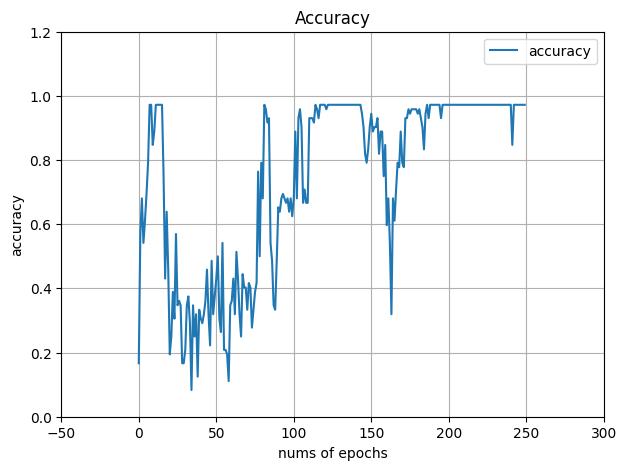

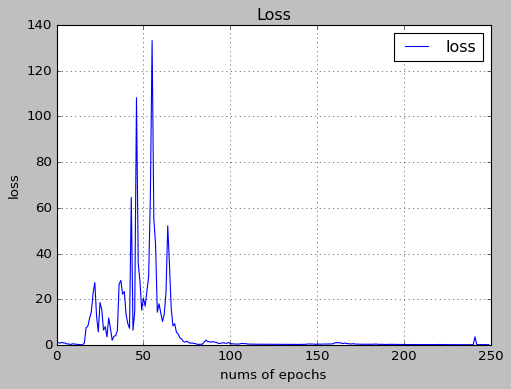

In [23]:
plt.figure(1,figsize=(7,5))
plt.plot(xc,train_acc)
plt.xlabel('nums of epochs')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.grid(True)
plt.legend(['accuracy'])
print(plt.style.available)
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_loss)
plt.xlabel('nums of epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.grid(True)
plt.legend(['loss'])
print(plt.style.available)
plt.style.use(['classic'])

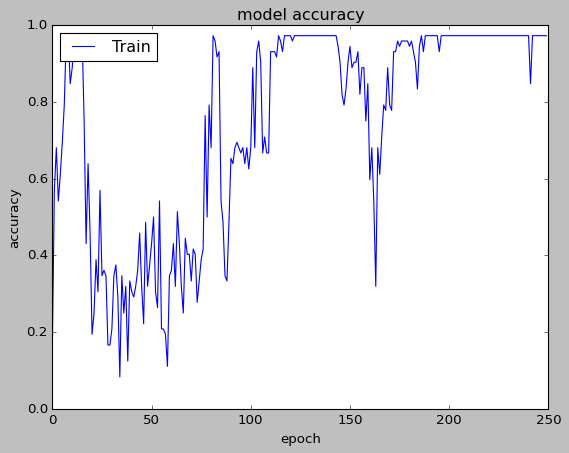

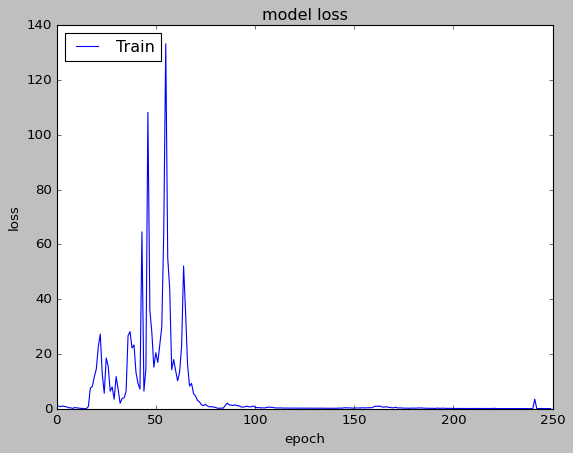

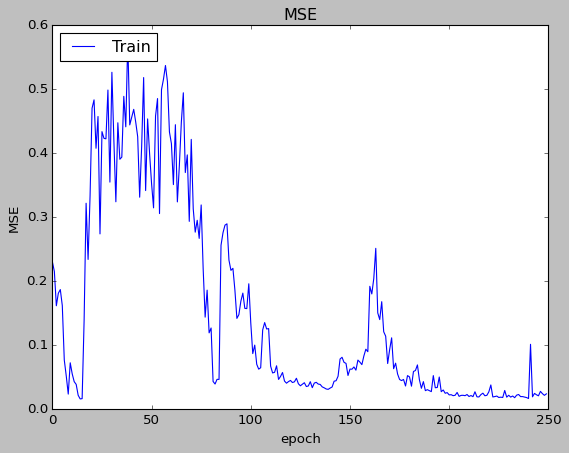

In [24]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(hist.history['accuracy'])
#plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
###############################################################################
plt.plot(hist.history['mse'])
#plt.plot(hist.history['val_mse'])
plt.title('MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            376064    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 530627 (2.02 MB)
Trainable params: 530627 

# Make Predictions

In [26]:
res=model.predict(X_test)

1/1 [==============================] - 0s 380ms/step


In [27]:
model.save('engagement_predictor.h5')

C:\Users\sriha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
actions[np.argmax(res[2])]

'active'

In [29]:
actions[np.argmax(y_test[2])]

'active'

In [ ]:
del model

In [ ]:
model=keras.models.load_model('engagement_predictor.h5')

# Evaluation using Confusion Matrix and Accuracy

In [30]:
from sklearn.metrics import multilabel_confusion_matrix,accuracy_score

In [31]:
yhat=model.predict(X_test)

1/1 [==============================] - 0s 41ms/step


In [32]:
ytrue=np.argmax(y_test,axis=1).tolist()
yhat=np.argmax(yhat,axis=1).tolist()

In [33]:
confusion_matrix=multilabel_confusion_matrix(ytrue,yhat)

In [34]:
print(confusion_matrix)

[[[10  0]
  [ 0  8]]

 [[13  0]
  [ 0  5]]

 [[13  0]
  [ 0  5]]]


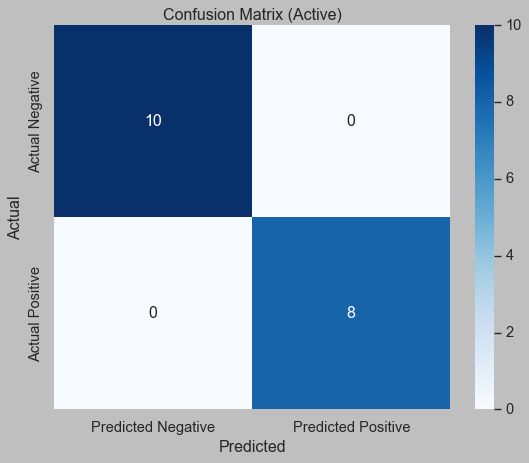

In [35]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size if needed
sns.heatmap(confusion_matrix[0], annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Active)")
plt.show()

In [36]:
accuracy=accuracy_score(ytrue,yhat)
error_rate=1-accuracy

print(accuracy)
print(error_rate)

1.0
0.0


# Testing the Program

In [37]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [38]:
from keras.preprocessing.image import ImageDataGenerator

sequence = []
sentence = []
threshold = 0.5

faceCascade=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

TrainingImagePath='Training Images'

#########################################################################
train_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')

TrainClasses=training_set.class_indices

ResultMap={}
for faceValue,faceName in zip(TrainClasses.values(),TrainClasses.keys()):
    ResultMap[faceValue]=faceName
    
import pickle
with open("ResultsMap.pkl", 'wb') as fileWriteStream:
    pickle.dump(ResultMap, fileWriteStream) 
    
##########################################################################

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        
        # Read feed
        ret, frames = cap.read()
        gray=cv2.cvtColor(frames,cv2.COLOR_BGR2GRAY)
        faces=faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(30, 30),flags=cv2.CASCADE_SCALE_IMAGE)
        
        
        # Detect the faces
        counter=0
        for (x,y,w,h) in faces:
            face = frames[y:y+h, x:x+w] #slice the face from the image
            # save each image in a separate file
            cv2.rectangle(frames, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.imwrite('face'+str(counter)+'.jpg',face)
            counter=counter+1

           #########################################################################

            '''########### Making single predictions ###########'''
            ImagePath='face'+str(counter)+'.jpg'
            test_image=keras.preprocessing.image.load_img(ImagePath,target_size=(64, 64))
            test_image=keras.preprocessing.image.img_to_array(test_image)

            test_image=np.expand_dims(test_image,axis=0)

            face_prediction_result=face_prediction_model.predict(test_image,verbose=0)
       
            #########################################################################
            # Make detections
            image, results = mediapipe_detection(face, holistic)
            print(results)

            # Draw landmarks
            draw_styled_landmarks(image, results)

            # 2. Prediction logic
            keypoints = extract_keypoints(results)
    #         sequence.insert(0,keypoints)
    #         sequence = sequence[:30]
            sequence.append(keypoints)
            sequence = sequence[-30:]

            if len(sequence) == 30:
                res = engagement_prediction_model.predict(np.expand_dims(sequence, axis=0))[0]
                print(actions[np.argmax(res)])

                
                cv2.putText(frames,ResultMap[np.argmax(face_prediction_result)]+ ' '+actions[np.argmax(res)], (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            # Show to screen
            cv2.imshow('OpenCV Feed', frames)

        # Break gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

Found 4201 images belonging to 3 classes.
Found 4201 images belonging to 3 classes.


error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\objdetect\src\cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'
